In [1]:
!pip install -q transformers timm

In [2]:
import torchvision
import os
import numpy as np
from PIL import Image, ImageDraw
from torch.utils.data import DataLoader
from transformers import DetrFeatureExtractor, DetrForObjectDetection
import torch.nn as nn
import torch

In [3]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [4]:
!pip install pycocotools

done
  Created wheel for pycocotools: filename=pycocotools-2.0.5-cp37-cp37m-linux_x86_64.whl size=373765 sha256=30d317907aa0c432ed3efc9e9dd2dcface519b2aa154a7905d9f6863aa4cfe24
  Stored in directory: /root/.cache/pip/wheels/85/c4/f0/7128093a134f590e4383fd60cb484960878721d98b9a515317
Successfully built pycocotools


In [5]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
train_dataset = CocoDetection(img_folder='../input/licenseplates2/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder='../input/licenseplates2/valid', feature_extractor=feature_extractor, train=False)

Downloading:   0%|          | 0.00/274 [00:00<?, ?B/s]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 456
Number of validation examples: 41


In [6]:

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [10]:
pixel_values, target = train_dataset[0]

In [7]:
device = 'cuda:0'

In [8]:
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=1,
                                                             ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,
                                  weight_decay=1e-4)

In [ ]:
model.train()
#torch.set_grad_enabled(True)

In [12]:
epochs = 15

In [13]:
def mean(numb: list):
    return sum(numb)/len(numb)

In [14]:
from transformers import get_linear_schedule_with_warmup
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, num_training_steps=total_steps)

In [15]:

for epoch in range(epochs):
 
 losses = []
 print('epoch: '+ str(epoch))
 for batch in train_dataloader:
    pixel_values = batch["pixel_values"]
    pixel_mask = batch["pixel_mask"]
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]
    pixel_values = pixel_values.to(device)
    pixel_mask = pixel_mask.to(device)
    outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
    loss = outputs.loss
    print(loss)
    

    optimizer.zero_grad()


    loss.backward()

    optimizer.step()
    scheduler.step()
    losses.append(loss)
 print('mean loss: ' + str(mean(losses)))

epoch: 0
tensor(4.8308, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.7407, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.1304, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.2818, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6039, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.2466, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0158, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5666, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8962, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.7802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.2736, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3638, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2979, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.5222, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.0767, device='cuda:0', grad_fn

In [16]:
torch.save(model, 'DETR15eps.pth')

In [17]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        #text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [18]:
def visualize_predictions(image, outputs, threshold=0.9, keep_highest_scoring_bbox=False):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  if keep_highest_scoring_bbox:
    keep = probas.max(-1).values.argmax()
    keep = torch.tensor([keep])
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    
  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [19]:
it = iter(range(1500))

torch.Size([1, 3, 800, 800])


NameError: name 'id2label' is not defined

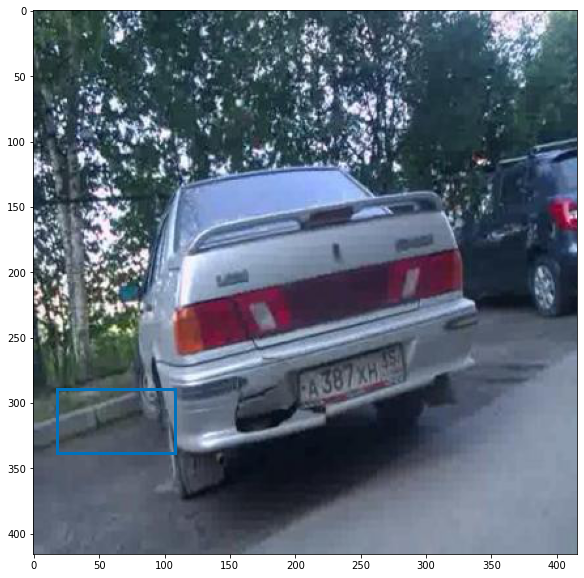

In [21]:
pixel_values, target = val_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)

# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('../input/licenseplates2/valid', image['file_name']))

visualize_predictions(image, outputs, threshold=0.3, keep_highest_scoring_bbox=True)

In [29]:
import matplotlib.pyplot as plt

In [30]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [31]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [32]:
def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [48]:
!pip install torchshow

In [ ]:
import torchshow

In [131]:
pixel_values, target = val_dataset[0]

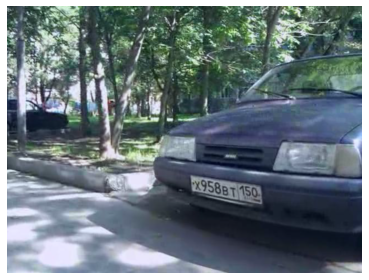

In [132]:
ts = torchshow.show(pixel_values)

In [57]:
pixel_values = pixel_values.unsqueeze(0).to(device)


In [127]:
outputs = model(pixel_values=pixel_values, pixel_mask=None)

In [129]:
outputs

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-2.2380,  2.6153],
         [-2.1983,  2.4459],
         [-2.2720,  2.1664],
         [-2.2966,  2.4919],
         [-2.4846,  2.3141],
         [-1.9344,  2.1169],
         [-1.8052,  2.1556],
         [-2.4026,  2.2313],
         [-2.5923,  2.5168],
         [-2.6556,  2.5315],
         [-2.1701,  2.7746],
         [-2.4625,  2.3332],
         [-2.1617,  2.2413],
         [-1.9486,  2.3379],
         [-2.2085,  2.6203],
         [-2.5281,  2.2620],
         [-2.7528,  2.9965],
         [-2.3600,  2.7517],
         [-1.9125,  2.3097],
         [-2.3867,  2.4153],
         [-2.1669,  2.5089],
         [-2.2464,  2.1941],
         [-2.0620,  2.1358],
         [-1.7731,  2.3160],
         [-1.9060,  2.3551],
         [-2.1422,  2.3613],
         [-2.3241,  2.0185],
         [-2.0922,  1.9572],
         [-2.2460,  2.5363],
         [-2.1254,  2.3103],
         [-2.2798,  2.7320],
         [-2.3103,  2.5351],
         [-2

In [125]:

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='red', alpha=0.5))
    plt.axis('off')
    plt.show()

In [144]:
def visualize_predictions(image, outputs, threshold=0.1):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  print((probas.max(-1).values).max())
  keep = (probas.max(-1).values).max()
  print(keep)
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [64]:
import torchvision.transforms as T

In [96]:
transform = T.ToPILImage(mode='RGB')

In [87]:
pixel_values1 = pixel_values.squeeze(0)

In [90]:
image = pixel_values.cpu().clone()
image = image.squeeze(0)

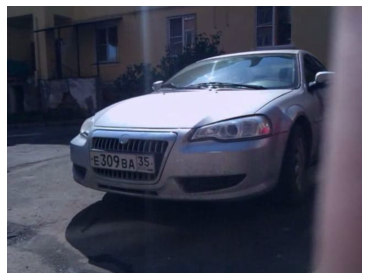

In [102]:
torchshow.show(image)

In [108]:
imagepic = image.numpy()

In [145]:

image = Image.open('../input/licenseplates/valid/12_6_2014_19_36_49_472_png.rf.fc8cc347582ce2b29c342a992b0dc2bd.jpg')

visualize_predictions(image, outputs)

tensor(0.0187, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0187, device='cuda:0', grad_fn=<MaxBackward1>)


IndexError: tensors used as indices must be long, byte or bool tensors